In [ ]:
!wget https://www.machinehack.com/wp-content/uploads/2020/06/E-Commerce_Participants_Data.zip

--2020-06-14 12:03:22--  https://www.machinehack.com/wp-content/uploads/2020/06/E-Commerce_Participants_Data.zip
Resolving www.machinehack.com (www.machinehack.com)... 107.180.71.20
Connecting to www.machinehack.com (www.machinehack.com)|107.180.71.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72178 (70K) [application/zip]
Saving to: ‘E-Commerce_Participants_Data.zip’

E-Commerce_Particip 100%[===================>]  70.49K   300KB/s    in 0.2s    

2020-06-14 12:03:23 (300 KB/s) - ‘E-Commerce_Participants_Data.zip’ saved [72178/72178]



In [ ]:
!unzip E-Commerce_Participants_Data.zip

Archive:  E-Commerce_Participants_Data.zip
   creating: E-Commerce_Participants_Data/
  inflating: E-Commerce_Participants_Data/Test.csv  
  inflating: __MACOSX/E-Commerce_Participants_Data/._Test.csv  
  inflating: E-Commerce_Participants_Data/Sample_Submission.xlsx  
  inflating: __MACOSX/E-Commerce_Participants_Data/._Sample_Submission.xlsx  
  inflating: E-Commerce_Participants_Data/Train.csv  
  inflating: __MACOSX/E-Commerce_Participants_Data/._Train.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train = pd.read_csv('E-Commerce_Participants_Data/Train.csv')
test = pd.read_csv('E-Commerce_Participants_Data/Test.csv')
sub = pd.read_excel('E-Commerce_Participants_Data/Sample_Submission.xlsx')

In [ ]:
train.head(2)

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2/3/2017,291.0
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,7/1/2015,897.0


In [ ]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape,train.dtypes

(Product          0
 Product_Brand    0
 Item_Category    0
 Subcategory_1    0
 Subcategory_2    0
 Item_Rating      0
 Date             0
 Selling_Price    0
 dtype: int64, Product          0
 Product_Brand    0
 Item_Category    0
 Subcategory_1    0
 Subcategory_2    0
 Item_Rating      0
 Date             0
 dtype: int64, (2452, 8), (1051, 7), Product           object
 Product_Brand     object
 Item_Category     object
 Subcategory_1     object
 Subcategory_2     object
 Item_Rating      float64
 Date              object
 Selling_Price    float64
 dtype: object)

In [ ]:
a=['Product','Product_Brand','Item_Category','Subcategory_1','Subcategory_2']
for i in a:
  print(train[i].nunique())
  print(test[i].nunique())

2452
1051
1010
494
75
47
130
93
336
194


In [ ]:
train['Product']=train.Product.str.extract('(\d+)')
test['Product']=test.Product.str.extract('(\d+)')
train['Product_Brand']=train.Product_Brand.str.extract('(\d+)')
test['Product_Brand']=test.Product_Brand.str.extract('(\d+)')
train['Product']=train['Product'].astype(int)
test['Product']=test['Product'].astype(int)
train['Product_Brand']=train['Product_Brand'].astype(int)
test['Product_Brand']=test['Product_Brand'].astype(int)

In [ ]:
a=['Item_Category','Subcategory_1','Subcategory_2']
for i in a:
  loc = np.append(train[i].values, test[i].values, axis=0)
  from sklearn.preprocessing import LabelEncoder
  l=LabelEncoder()
  l.fit(list(set(loc)))
  train[i]=l.transform(train[i])
  test[i]=l.transform(test[i])

In [ ]:
k=['Date']
for i in k:
  train[i] = pd.to_datetime(train[i])
  test[i] = pd.to_datetime(test[i])

In [ ]:
k=['Date']
for i in k:
  test[i+'_'+'year'] = test[i].dt.year
  test[i+'_'+'day'] = test[i].dt.day
  test[i+'_'+'weekofyear'] = test[i].dt.weekofyear
  test[i+'_'+'month'] = test[i].dt.month
  test[i+'_'+'dayofweek'] =test[i].dt.dayofweek
  test[i+'_'+'weekend'] = (test[i].dt.weekday >=5).astype(int)
  train[i+'_'+'year'] = train[i].dt.year
  train[i+'_'+'day'] = train[i].dt.day
  train[i+'_'+'weekofyear'] = train[i].dt.weekofyear
  train[i+'_'+'month'] = train[i].dt.month
  train[i+'_'+'dayofweek'] = train[i].dt.dayofweek
  train[i+'_'+'weekend'] = (train[i].dt.weekday >=5).astype(int)

In [ ]:
del train['Date']
del test['Date']

In [ ]:
train_df=train
test_df=test

In [ ]:

train_df['Selling_Price'] = np.log1p(train_df['Selling_Price'])

In [ ]:
X = train_df.drop(labels=['Selling_Price'], axis=1)
y = train_df['Selling_Price'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.15, random_state=1)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((2084, 12), (2084,), (368, 12), (368,))

In [ ]:
from math import sqrt 
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [ ]:
Xtest = test

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

errxgb = []
y_pred_totxgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #xgb = XGBRegressor(random_state=101)
    xgb=XGBRegressor(random_state=101, n_jobs=-1, objective="reg:squarederror", max_depth=6, n_estimators=100)
    xgb.fit(X_train, y_train)

    y_pred_xgb = xgb.predict(X_test)
    print("RMSLE: ", sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_xgb))))

    errxgb.append(sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_xgb))))
    p = xgb.predict(Xtest)
    y_pred_totxgb.append(p)

RMSLE:  0.6826770612716584
RMSLE:  0.6911256827604669
RMSLE:  0.6563224869397651
RMSLE:  0.7262156429357038
RMSLE:  0.7424623173797228
RMSLE:  0.6560205544514041
RMSLE:  0.6725028194895626
RMSLE:  0.7106527443811484
RMSLE:  0.6463168330460839
RMSLE:  0.6007286945564182


In [ ]:
np.mean(errxgb,0)

0.6785024837211934

In [ ]:
final1 = np.exp(np.mean(y_pred_totxgb,0))

In [ ]:
sub['Selling_Price'] = final1

In [ ]:
sub.head()

,Selling_Price
0,2036.922729
1,460.247498
2,812.690857
3,344.432434
4,763.906494


In [ ]:
sub.to_excel('ff.xlsx', index=False)

In [ ]:
from google.colab import files
files.download('ff.xlsx')

# f2

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(verbose=1, learning_rate=0.6, n_estimators=500, random_state=42, subsample=0.8)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_cv)
print('RMSLE', sqrt(mean_squared_log_error(np.exp(y_cv), np.exp(y_pred))))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7866           0.5714            4.29s
         2           0.6565           0.1222            3.38s
         3           0.5523           0.0608            2.84s
         4           0.5607           0.0180            2.57s
         5           0.5128           0.0396            2.41s
         6           0.4894           0.0060            2.31s
         7           0.4786           0.0006            2.30s
         8           0.4650           0.0073            2.30s
         9           0.4686           0.0047            2.30s
        10           0.4632           0.0007            2.30s
        20           0.3868          -0.0036            1.93s
        30           0.3254          -0.0042            1.78s
        40           0.2782          -0.0065            1.68s
        50           0.2510          -0.0026            1.61s
        60           0.2233          -0.0063            1.57s
       

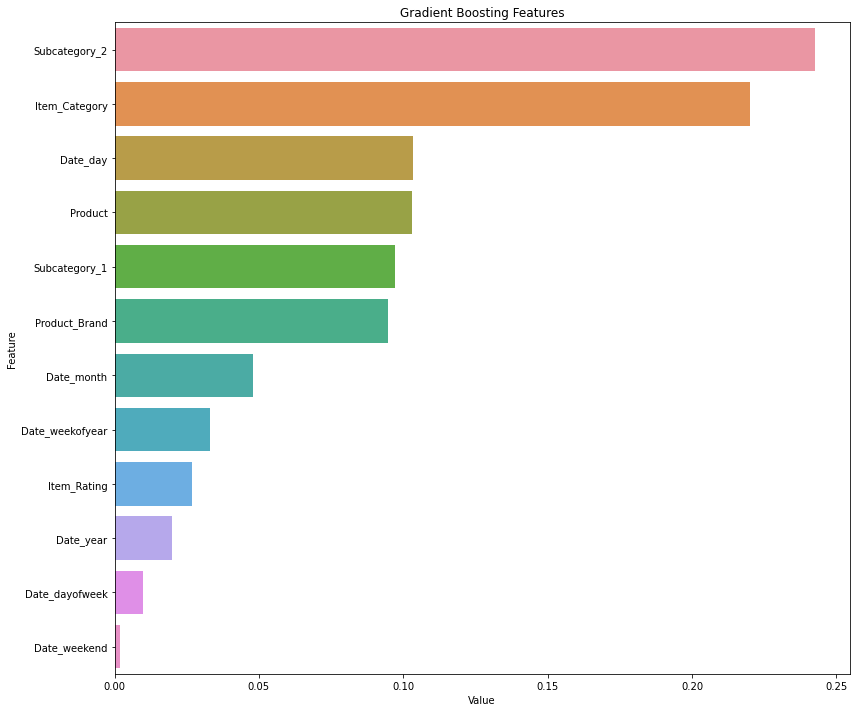

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(gb.feature_importances_, X.columns), reverse=True)[:60], columns=['Value','Feature'])
plt.figure(figsize=(12,10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Gradient Boosting Features')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import KFold

errgb = []
y_pred_totgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=42)#42

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    gb = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000, random_state=2015, subsample=0.9) #42        
    #gb = GradientBoostingRegressor(learning_rate=0.5, n_estimators=1000, random_state=42, subsample=0.8)
    #gb = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000, random_state=42, subsample=0.8)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)

    print('RMSE', sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred))))

    errgb.append(sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred))))
    p = gb.predict(Xtest)
    y_pred_totgb.append(p)

RMSE 0.6835021628362353
RMSE 0.6494507256015807
RMSE 0.6913450668871866
RMSE 0.7596155282385544
RMSE 0.7181877833862277
RMSE 0.6430768341201869
RMSE 0.6906445646005474
RMSE 0.7272071347739266
RMSE 0.7063669699074995
RMSE 0.6244886123313579


In [ ]:
np.mean(errgb)

0.6893885382683302

In [ ]:
final2 = np.exp(np.mean(y_pred_totgb,0))

In [ ]:
sub['Selling_Price'] = final2

In [ ]:
sub.head()

,Selling_Price
0,1843.743730
1,514.051477
2,810.171754
3,346.431216
4,708.433156


In [ ]:
sub.to_excel('avg_gb.xlsx', index=False)

In [ ]:
from google.colab import files
files.download('avg_gb.xlsx')

# f3

In [ ]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.01, 
         'num_iterations': 1000,
         'num_leaves': 30,
         'max_depth': -1,
         'min_data_in_leaf': 4,
         'bagging_fraction': 0.8,
         'bagging_freq': 1,
         'feature_fraction': 0.8,
         }

lgbm = lgb.train(params=param,
                 verbose_eval=100,
                 early_stopping_rounds=50,
                 train_set=train_data,
                 valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('RMSLE:', sqrt(mean_squared_log_error(np.exp(y_cv), np.exp(y_pred_lgbm))))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 0.76299
[200]	valid_0's rmse: 0.634739
[300]	valid_0's rmse: 0.575724
[400]	valid_0's rmse: 0.539052
[500]	valid_0's rmse: 0.510173
[600]	valid_0's rmse: 0.488031
[700]	valid_0's rmse: 0.468116
[800]	valid_0's rmse: 0.45033
[900]	valid_0's rmse: 0.432741
[1000]	valid_0's rmse: 0.419495
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.419495
RMSLE: 0.4186614054334283


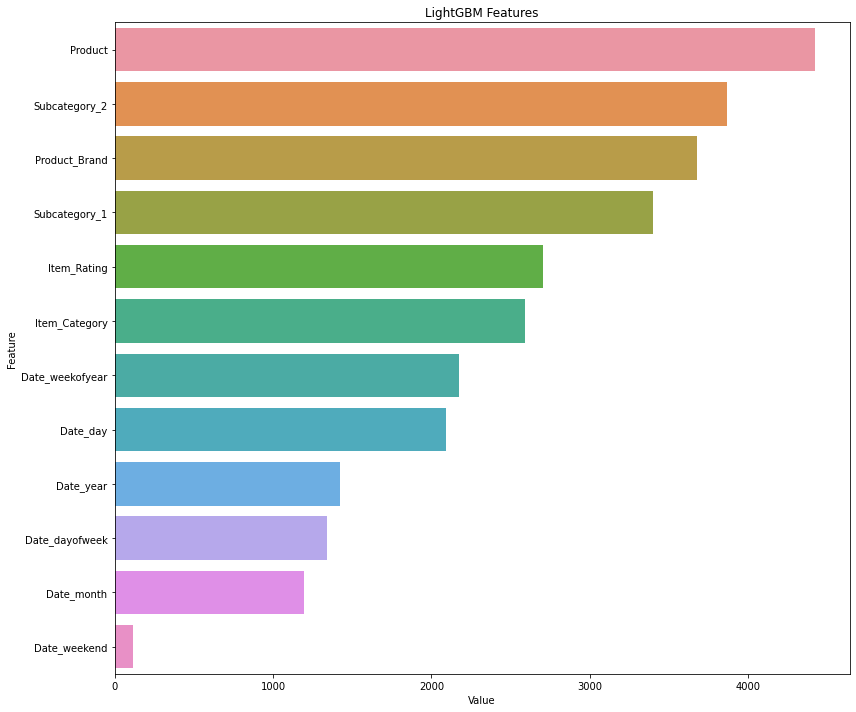

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=169)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(**param)
    #lgbm = LGBMRegressor(boosting_type='gbdt', num_leaves=100, max_depth=31, learning_rate=0.1, n_estimators=4000, min_child_samples=20, subsample=0.90,bagging_fraction=0.9)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_log_error(np.exp(y_test),np.exp(y_pred_lgbm))))

    errlgb.append(sqrt(mean_squared_log_error(np.exp(y_test),np.exp(y_pred_lgbm))))
    p = lgbm.predict(Xtest)
    y_pred_totlgb.append(p)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.6331408306768548


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.6550960715415013


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.7110494469338143


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.5835019590458035


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.7050042785144753


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.6758756692144549


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.6405594419161209


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.5798988389703911


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.7193689930195445


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.7050703942651202


In [ ]:
np.mean(errlgb)

0.660856592409808

In [ ]:
final3 = np.exp(np.mean(y_pred_totlgb,0))

In [ ]:
sub['Selling_Price'] = final3

In [ ]:
sub.head()

,Selling_Price
0,2133.547830
1,454.866788
2,778.161383
3,348.493260
4,746.937603


In [ ]:
sub.to_excel('lgbb.xlsx', index=False)

In [ ]:
from google.colab import files
files.download('lgbb.xlsx')

#f4

In [ ]:
!pip install catboost

In [ ]:
import catboost
cat = CatBoostRegressor(verbose=100, learning_rate=0.1, n_estimators=1000, random_state=42, subsample=0.8)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_cv)
print('RMSLE', sqrt(mean_squared_log_error(np.exp(y_cv), np.exp(y_pred))))

0:	learn: 1.1058573	total: 2.65ms	remaining: 2.64s
100:	learn: 0.5820592	total: 191ms	remaining: 1.7s
200:	learn: 0.4993503	total: 377ms	remaining: 1.5s
300:	learn: 0.4374224	total: 568ms	remaining: 1.32s
400:	learn: 0.3866166	total: 763ms	remaining: 1.14s
500:	learn: 0.3506606	total: 952ms	remaining: 948ms
600:	learn: 0.3153745	total: 1.14s	remaining: 757ms
700:	learn: 0.2867077	total: 1.33s	remaining: 566ms
800:	learn: 0.2599898	total: 1.51s	remaining: 376ms
900:	learn: 0.2382255	total: 1.71s	remaining: 188ms
999:	learn: 0.2186069	total: 1.89s	remaining: 0us
RMSLE 0.31194556306846727


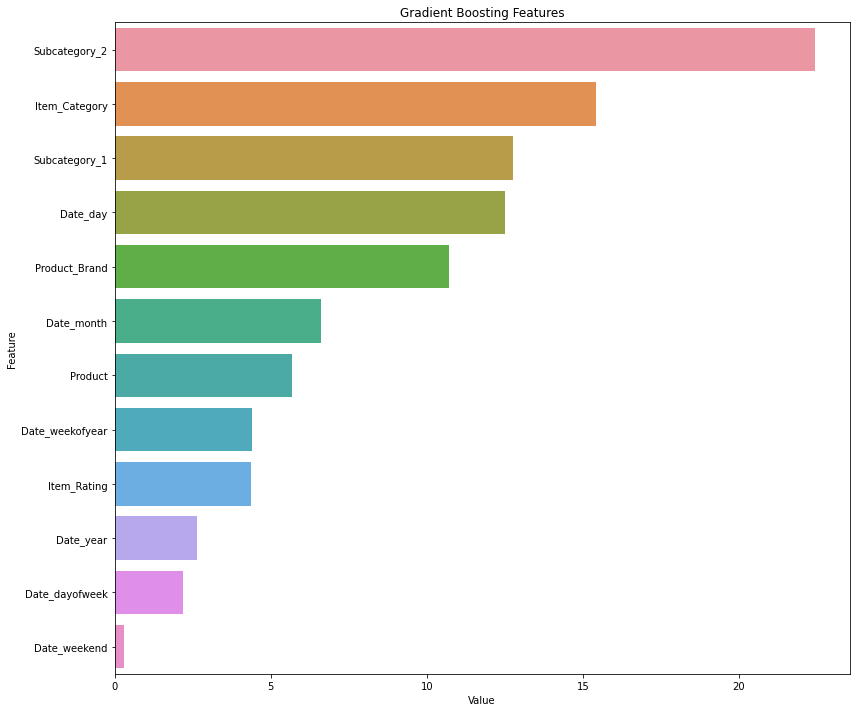

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:60], columns=['Value','Feature'])
plt.figure(figsize=(12,10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Gradient Boosting Features')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import KFold

errcat = []
y_pred_totcat = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)#42

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #cat = CatBoostRegressor(verbose=500, learning_rate=0.1, n_estimators=500, random_state=101, subsample=0.9)
    cat= CatBoostRegressor(iterations=None,learning_rate=None,depth=None,l2_leaf_reg=None,model_size_reg=None,rsm=None,loss_function='RMSE',border_count=None,feature_border_type=None,per_float_feature_quantization=None,input_borders=None,
                           output_borders=None,fold_permutation_block=None,od_pval=None,od_wait=None,od_type=None,nan_mode=None,counter_calc_method=None,leaf_estimation_iterations=None,
                           leaf_estimation_method=None,thread_count=None,random_seed=None,use_best_model=None,best_model_min_trees=None,verbose=None,silent=None,logging_level=None,metric_period=None,ctr_leaf_count_limit=None,
                           store_all_simple_ctr=None,max_ctr_complexity=None,has_time=None,allow_const_label=None,one_hot_max_size=None,random_strength=None,name=None,ignored_features=None,train_dir=None,custom_metric=None,
                           eval_metric=None,bagging_temperature=None,save_snapshot=None,snapshot_file=None,snapshot_interval=None,fold_len_multiplier=None,used_ram_limit=None,gpu_ram_part=None,pinned_memory_size=None,allow_writing_files=None,
                           final_ctr_computation_mode=None,approx_on_full_history=None,boosting_type=None,simple_ctr=None,combinations_ctr=None,per_feature_ctr=None,ctr_target_border_count=None,task_type=None,device_config=None,devices=None,
                           bootstrap_type=None,subsample=None,sampling_unit=None,dev_score_calc_obj_block_size=None,max_depth=None,n_estimators=None,num_boost_round=None,num_trees=None,colsample_bylevel=None,random_state=None,reg_lambda=None,
                           objective=None,eta=None,max_bin=None,gpu_cat_features_storage=None,data_partition=None,metadata=None,early_stopping_rounds=None,cat_features=None,grow_policy=None,min_data_in_leaf=None,min_child_samples=None,
                           max_leaves=None,num_leaves=None,score_function=None,leaf_estimation_backtracking=None,ctr_history_unit=None,monotone_constraints=None,feature_weights=None,penalties_coefficient=None,first_feature_use_penalties=None,
                           model_shrink_rate=None,model_shrink_mode=None,langevin=None,diffusion_temperature=None,boost_from_average=None)
    cat.fit(X_train, y_train)
    y_pred = cat.predict(X_test)

    print('RMSE', sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred))))

    errcat.append(sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred))))
    p = cat.predict(Xtest)
    y_pred_totcat.append(p)

0:	learn: 1.1131895	total: 2.37ms	remaining: 235ms
1:	learn: 1.0625518	total: 4.63ms	remaining: 227ms
2:	learn: 1.0204899	total: 6.88ms	remaining: 222ms
3:	learn: 0.9844022	total: 9.12ms	remaining: 219ms
4:	learn: 0.9506036	total: 11.3ms	remaining: 215ms
5:	learn: 0.9186995	total: 13.4ms	remaining: 210ms
6:	learn: 0.8879245	total: 15.8ms	remaining: 210ms
7:	learn: 0.8635421	total: 17.9ms	remaining: 206ms
8:	learn: 0.8441452	total: 20.1ms	remaining: 203ms
9:	learn: 0.8274413	total: 22.4ms	remaining: 201ms
10:	learn: 0.8105494	total: 24.6ms	remaining: 199ms
11:	learn: 0.7963649	total: 26.6ms	remaining: 195ms
12:	learn: 0.7826455	total: 28.7ms	remaining: 192ms
13:	learn: 0.7697664	total: 30.7ms	remaining: 189ms
14:	learn: 0.7608378	total: 32.6ms	remaining: 185ms
15:	learn: 0.7532984	total: 34.6ms	remaining: 182ms
16:	learn: 0.7465035	total: 36.5ms	remaining: 178ms
17:	learn: 0.7381747	total: 38.6ms	remaining: 176ms
18:	learn: 0.7316878	total: 40.3ms	remaining: 172ms
19:	learn: 0.7259408	t

In [ ]:
np.mean(errcat)

0.6928971856646058

In [ ]:
final4 = np.exp(np.mean(y_pred_totcat,0))

In [ ]:
sub['Selling_Price'] = final4

In [ ]:
sub.head()

,Selling_Price
0,2057.041411
1,439.949519
2,801.496517
3,345.155400
4,780.588641


In [ ]:
sub.to_excel('pipe101.xlsx', index=False)

In [ ]:
from google.colab import files
files.download('pipe101.xlsx')

#ensem


In [ ]:
final=final1*0.2+final2*0.4+final3*0.3+final4*0.1

In [ ]:
final=final1*0.15+final2*0.5+final3*0.25+final4*0.1

In [ ]:
sub['Selling_Price'] = final

In [ ]:
sub.head()

,Selling_Price
0,1973.672036
1,480.103594
2,802.557053
3,345.370069
4,731.005673


In [ ]:
sub.to_excel('pipeline_1.xlsx', index=False)

In [ ]:
from google.colab import files
files.download('pipeline_1.xlsx')